In [1]:
# Cell 1: Setup and imports
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'  # You can change to 'jax' or 'torch' if preferred

import numpy as np
import keras
import sentencepiece as spm

print(f"Keras version: {keras.__version__}")
print(f"Keras backend: {keras.config.backend()}")

2025-11-23 21:53:47.595570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763927627.635532  184457 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763927627.647994  184457 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763927627.697544  184457 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763927627.697570  184457 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763927627.697571  184457 computation_placer.cc:177] computation placer alr

Keras version: 3.12.0
Keras backend: tensorflow


In [2]:
# Cell 2: Load and prepare text data
# Load the Kalevala text
with open('./seitsemanveljesta.txt', 'r', encoding='utf-8-sig') as file:
    text = file.read()

print(f"Text length: {len(text)} characters")
print(f"First 100 characters: {text[:100]}")

Text length: 627004 characters
First 100 characters: ENSIMMÄINEN LUKU


Jukolan talo, eteläisessä Hämeessä, seisoo erään mäen pohjaisella
rinteellä, liki


In [ ]:
# Cell 3: Train SentencePiece model
# Save text to a temporary file for SentencePiece training
temp_file = 'seitsemanveljesta_temp.txt'
with open(temp_file, 'w', encoding='utf-8') as f:
    f.write(text)

# Train SentencePiece model
vocab_size = 10000  # You can adjust this based on your needs
model_prefix = 'seitsemanveljesta_sp'

spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=1.0,  # Important for Finnish
    model_type='bpe',
    user_defined_symbols=['<PAD>', '<UNK>']
)

# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# Test tokenization
test_text = "Jukolan emäntä"
tokens = sp.encode_as_pieces(test_text)
print(f"Tokenized example: {tokens}")
print(f"Vocabulary size: {sp.get_piece_size()}")

Tokenized example: ['▁Jukolan', '▁emäntä']
Vocabulary size: 10000


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: seitsemanveljesta_temp.txt
  input_format: 
  model_prefix: seitsemanveljesta_sp
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <PAD>
  user_defined_symbols: <UNK>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>


y
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=18 size=2260 all=32876 active=2007 piece=▁päätä
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=18 size=2280 all=32934 active=2065 piece=▁kuullut
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=2300 all=33008 active=2139 piece=las
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=17 min_freq=10
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=2320 all=33167 active=1796 piece=KKARI
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=2340 all=33271 active=1900 piece=▁synt
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=2360 all=33337 active=1966 piece=▁nummen
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=2380 all=33365 active=1994 piece=▁päällensä
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2400 all=33492 active=2121 piece=kill
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=16 min_freq=9
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2420 

In [4]:
# Cell 4: Prepare training data
# Tokenize the text
seq_length = 64
pieces = sp.encode_as_ids(text)
print(f"Total tokens: {len(pieces)}")

# Create sequences
sequences = []
for i in range(0, len(pieces) - seq_length):
    # Input: first seq_length tokens, Target: next seq_length tokens (shifted by 1)
    sequences.append(pieces[i:i+seq_length+1])

# Convert to NumPy arrays
sequences = np.array(sequences)
inputs = sequences[:, :-1]  # All tokens except the last one
targets = sequences[:, 1:]  # All tokens except the first one

print(f"Number of sequences: {len(sequences)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

# Split into training and validation sets
indices = np.arange(len(sequences))
np.random.shuffle(indices)

train_size = int(0.8 * len(sequences))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_inputs, train_targets = inputs[train_indices], targets[train_indices]
val_inputs, val_targets = inputs[val_indices], targets[val_indices]

Total tokens: 135193
Number of sequences: 135129
Input shape: (135129, 64)
Target shape: (135129, 64)


In [5]:
# Cell 5: Define the model
def get_positional_encoding(max_len, d_model):
    """Create sinusoidal positional encoding."""
    positions = np.arange(max_len)[:, np.newaxis]
    angles = np.arange(d_model)[np.newaxis, :] / d_model
    angles = 1 / (10000**angles)

    pos_encoding = positions * angles
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return pos_encoding

# Define model parameters
embed_dim = 192 #192 --> 128 --> 256
num_heads = 4 # 4 --> 8
ff_dim = 384 #min 256 if training takes too long | 384 --> 300 --> 768
num_layers = 2

# Create the model
inputs = keras.Input(shape=(seq_length,))
embedding_layer = keras.layers.Embedding(sp.get_piece_size(), embed_dim)(inputs)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_length, embed_dim)
x = embedding_layer + pos_encoding

# Transformer blocks
for _ in range(num_layers):
    # Multi-head attention with causal mask
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=0.1
    )(x, x, use_causal_mask=True)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ffn = keras.Sequential([
        keras.layers.Dense(ff_dim, activation="relu"),
        keras.layers.Dense(embed_dim),
        keras.layers.Dropout(0.1)
    ])
    ffn_output = ffn(x)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

# Final output layer
outputs = keras.layers.Dense(sp.get_piece_size())(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1763927635.547361  184457 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8420 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 192)   │  1,920,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 192)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 192)   │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 192)   │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 192)   │    148,032 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 192)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 192)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 192)   │    148,032 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 192)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 10000) │  1,930,000 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,444,048 (16.95 MB)

 Trainable params: 4,444,048 (16.95 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6: Train the model
batch_size = 128
epochs = 50

history = model.fit(
    train_inputs, train_targets,
    validation_data=(val_inputs, val_targets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
        keras.callbacks.ModelCheckpoint('seitsemanveljesta_best_model.keras', save_best_only=True)
    ]
)

Epoch 1/50


I0000 00:00:1763927651.100683  184597 service.cc:152] XLA service 0x7faec40030a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763927651.100759  184597 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-23 21:54:11.234868: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 21:54:11.554949: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1763927651.965158  184597 cuda_dnn.cc:529] Loaded cuDNN version 91400


  3/845 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - accuracy: 0.0000e+00 - loss: 9.2372 

I0000 00:00:1763927656.789535  184597 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0618 - loss: 8.2287

2025-11-23 21:54:41.936901: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0618 - loss: 8.2277

2025-11-23 21:54:46.581610: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-11-23 21:54:49.624918: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


845/845 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.0666 - loss: 7.8315 - val_accuracy: 0.0720 - val_loss: 7.5639 - learning_rate: 5.0000e-05
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.1048 - loss: 7.1694 - val_accuracy: 0.1209 - val_loss: 6.7220 - learning_rate: 5.0000e-05
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.1277 - loss: 6.4932 - val_accuracy: 0.1397 - val_loss: 6.2266 - learning_rate: 5.0000e-05
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.1517 - loss: 6.0516 - val_accuracy: 0.1719 - val_loss: 5.7364 - learning_rate: 5.0000e-05
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.1822 - loss: 5.5688 - val_accuracy: 0.1997 - val_loss: 5.2231 - learning_rate: 5.0000e-05
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.2049 - loss: 5.0958 - val_accuracy: 0.2175 - val_loss: 4.7880 - learning_rate: 5.0000e-05
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accurac

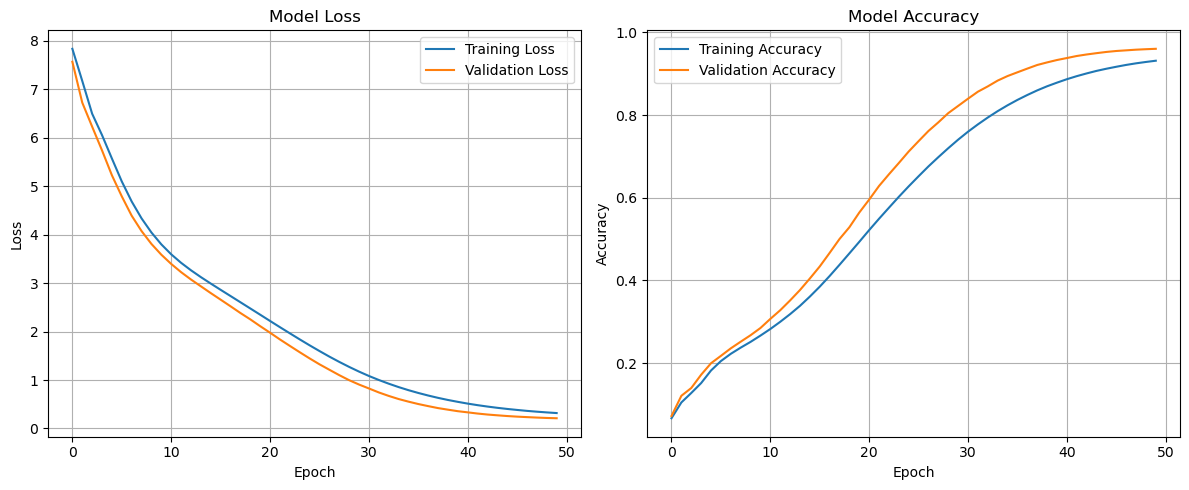

In [7]:
# Cell 7: Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Save the model
model.save('seitsemanveljesta_keski_model.keras')
print("Model saved as 'seitsemanveljesta_keski_model.keras'")

Model saved as 'seitsemanveljesta_keski_model.keras'


In [9]:
def generate_text(model, sp, prompt, num_tokens=100, temperature=1.0):
    """
    Generate text autoregressively.

    Args:
        temperature: Controls randomness
            - Low (0.1-0.5): Focused, repetitive
            - Medium (0.7-1.0): Balanced
            - High (1.5+): Creative, chaotic
    """
    # Encode the prompt
    input_ids = sp.encode_as_ids(prompt)

    # Rest of your generation code stays the same...
    if len(input_ids) < seq_length:
        padding_length = seq_length - len(input_ids)
        input_ids = [0] * padding_length + input_ids
    else:
        padding_length = 0
        input_ids = input_ids[-seq_length:]

    # Generated tokens
    generated_ids = list(input_ids[padding_length:])

    # Generate text token by token
    for _ in range(num_tokens):
        x = np.array([input_ids])
        predictions = model.predict(x, verbose=0)[0]
        logits = predictions[-1]
        logits = logits / temperature
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)
        next_token = np.random.choice(len(probs), p=probs)
        generated_ids.append(next_token)
        input_ids = input_ids[1:] + [next_token]

    # Decode the generated sequence
    generated_text = sp.decode(generated_ids)

    return generated_text

In [10]:
# Cell 10: Generate sample text
prompts = [
    "Jukolan emäntä",
    "Taivaan enkeli",
    "Veli",
    "Mutta viimein"
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    generated = generate_text(model, sp, prompt, num_tokens=100, temperature=0.8) # Changed temperature from 1.2 to 1.0, 1.0 --> 0.8
    print(generated)


Prompt: Jukolan emäntä
Jukolan emäntä! AAPO. Tuomas kalvenee! Jumala auttakoon meitä! Tuomas kalvenee! JUHANI. Tekisitkö hirmutöitä? Veljeni, veljeni! TUOMAS. Menkäät, äijä! JUHANI. Ah! minä olisin kantanut hänen iloiseen kalaasiin, kantanut kuin pienen lapsen; sillä säkeniä säihkyy karvainen poveni. Herran poika! kenen paulasta olen minä naappaisnut lintua? Lintua tai jänistä? Vai tahdotko korvilles? TUOMAS. Vioitinko jalkas? JUHANI. Mitä

Prompt: Taivaan enkeli
Taivaan enkeli ilmestyisi kaikelle, miestä kaataa kaskea kymmenet tynnörin-alat muutamana päivänä. Kasken poltamme, kylvämme ja leikkaamme viimein ja jyvät viemme härkien hintana Viertolaan, jätämme kuitenkin aittaamme osan omiksi tarpeiksemme. Ja siinä on meillä jalo seljänvastus. Niin, tuolla on entinen, armas Jukola, tuolla Toukolan kylä, tuolla kirkontorni vapisi ja tyyni kuin liepeästi paistoi aurinko vaaleansiniseltä, hymyävältä taivaalta. Tuli

Prompt: Veli
Veli Timo, poikaseni, sinä hirveä mies. TIMO. »Toisen kerran t

In [11]:
# Cell 11: Load model (if you're starting a new session)
# Uncomment these lines to load a previously saved model
'''
# Load saved model
model = keras.models.load_model('seitsemanveljesta_model_raskas.keras')

# Load SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load('seitsemanveljesta_raskas_sp.model')
# Test generation
prompt = "Mutta viimein"
generated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)
print(generated)
'''


'\n# Load saved model\nmodel = keras.models.load_model(\'seitsemanveljesta_model_raskas.keras\')\n\n# Load SentencePiece tokenizer\nsp = spm.SentencePieceProcessor()\nsp.load(\'seitsemanveljesta_raskas_sp.model\')\n# Test generation\nprompt = "Mutta viimein"\ngenerated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)\nprint(generated)\n'